In [1]:
%matplotlib inline
import os
import imp
import warnings
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from mpl_toolkits.basemap import Basemap

warnings.simplefilter('ignore')

In [3]:
# Path to the root directory of MelbDatathon2017. 
data_dir = os.path.join(os.path.expanduser('~'), 'MelbDatathon2017')

In [4]:
fd_trans = os.path.join(data_dir, "Transactions.h5")
print(fd_trans)

fd_atc = os.path.join(data_dir, "Lookups", "ATC_LookUp.txt")
print(fd_atc)

fd_ci = os.path.join(data_dir, "Lookups", "ChronicIllness_LookUp.txt")
print(fd_ci)

fd_drugs = os.path.join(data_dir, "Lookups", "Drug_LookUp.txt")
print(fd_drugs)

fd_patients = os.path.join(data_dir, "Lookups", "patients.txt")
print(fd_patients)

fd_stores = os.path.join(data_dir, "Lookups", "stores.txt")
print(fd_stores)

/Users/lvalenti/MelbDatathon2017/Transactions.h5
/Users/lvalenti/MelbDatathon2017/Lookups/ATC_LookUp.txt
/Users/lvalenti/MelbDatathon2017/Lookups/ChronicIllness_LookUp.txt
/Users/lvalenti/MelbDatathon2017/Lookups/Drug_LookUp.txt
/Users/lvalenti/MelbDatathon2017/Lookups/patients.txt
/Users/lvalenti/MelbDatathon2017/Lookups/stores.txt


In [5]:
postcode_lookup = pd.read_csv(os.path.join(data_dir, 'Extra', "Australian_Post_Codes_Lat_Lon.csv"), index_col=0)

def get_latlon(postcode):
    """
    The same postcode can be used for multiple localities, so we need to check.
    """
    try:
        rslt = postcode_lookup.xs(postcode)
    except KeyError:
        print("Postcode {} not found".format(postcode))
        return None, None
    
    if np.isscalar(rslt.lat):
        lat = rslt.lat
        lon = rslt.lon
    else:
        lat = rslt.lat.iloc[0]
        lon = rslt.lon.iloc[0]
        
    return lat, lon

In [6]:
# Main dataframe, takes a bit of time to load.
# I have merged all patients file into a single hdf file.
datafr = pd.read_hdf(fd_trans)

In [7]:
# All the lookup tables.
stores_frame = pd.read_csv(fd_stores, sep="\t", index_col=0)
patient_frame = pd.read_csv(fd_patients, sep="\t", na_values=1900, index_col=0, dtype={'Patient_id':int, 'gender':str, 'postcode':int})
drug_frame = pd.read_csv(fd_drugs, sep="\t", index_col=0)

In [8]:
# This one is gonna be fun!
drug_frame[drug_frame.BrandName == 'VIAGRA']

,MasterProductCode,MasterProductFullName,BrandName,FormCode,StrengthCode,PackSizeNumber,GenericIngredientName,EthicalSubCategoryName,EthicalCategoryName,ManufacturerCode,ManufacturerName,ManufacturerGroupID,ManufacturerGroupCode,ChemistListPrice,ATCLevel5Code,ATCLevel4Code,ATCLevel3Code,ATCLevel2Code,ATCLevel1Code
MasterProductID,,,,,,,,,,,,,,,,,,,
9039,VIAG2,VIAGRA TAB 50MG 4,VIAGRA,TAB,50MG,4.0,SILDENAFIL,NON PBS Substitutable,ETHICAL NON PBS,PF,PFIZER AUSTRALIA PTY LTD,192,PFIZER,66.60,G04BE03,G04BE,G04B,G04,G
9038,VIAG1,VIAGRA TAB 25MG 4,VIAGRA,TAB,25MG,4.0,SILDENAFIL,NON PBS Substitutable,ETHICAL NON PBS,PF,PFIZER AUSTRALIA PTY LTD,192,PFIZER,52.32,G04BE03,G04BE,G04B,G04,G
9040,VIAG3,VIAGRA TAB 100MG 4 4,VIAGRA,TAB,100MG,4.0,SILDENAFIL,NON PBS Substitutable,ETHICAL NON PBS,PF,PFIZER AUSTRALIA PTY LTD,192,PFIZER,72.04,G04BE03,G04BE,G04B,G04,G
9041,VIAG4,VIAGRA TAB 100MG 12 12,VIAGRA,TAB,100MG,12.0,SILDENAFIL,NON PBS Substitutable,ETHICAL NON PBS,PF,PFIZER AUSTRALIA PTY LTD,192,PFIZER,160.00,G04BE03,G04BE,G04B,G04,G


In [9]:
# The Generic name and the brand name gives the same results.
# viagra_index = drug_frame[drug_frame.GenericIngredientName == 'SILDENAFIL'].index
viagra_index = drug_frame[drug_frame.BrandName == 'VIAGRA'].index

In [10]:
viagra_patients = datafr.xs(viagra_index[0], level='Drug_ID')
for viagra_slice in viagra_index[1:]:
    try:
        viagra_patients.append(datafr.xs(viagra_slice, level='Drug_ID'))
    except KeyError:
        print('Drug ID not found in database: ', viagra_slice)

In [11]:
# Adding info from the patients lookup table into the main db.
viagra = viagra_patients.combine_first(patient_frame)

In [13]:
# freq = viagra.postcode.value_counts()
# freq_postcode = np.array(freq.index.astype(int))
# freq_cnt = np.array(freq)

In [146]:
drug_frame[drug_frame.MasterProductCode.str.contains('VIAG')].MasterProductCode

MasterProductID
9039    VIAG2
9038    VIAG1
9040    VIAG3
9041    VIAG4
Name: MasterProductCode, dtype: object

In [29]:
# I want to determine the average price for one pill.
drug_frame[drug_frame.MasterProductCode.str.contains('VIAG')].PackSizeNumber

MasterProductID
9039     4.0
9038     4.0
9040     4.0
9041    12.0
Name: PackSizeNumber, dtype: float64

In [30]:
# For a further study, the average price by grams.
drug_frame[drug_frame.MasterProductCode.str.contains('VIAG')].StrengthCode

MasterProductID
9039     50MG
9038     25MG
9040    100MG
9041    100MG
Name: StrengthCode, dtype: object

In [147]:
# Lets create a new lookup table containting the nb of pills for each different viagra box.
nw_lt = pd.DataFrame({'Drug_Code':['VIAG1', 'VIAG2', 'VIAG3', 'VIAG4'], 'qtt': [4, 8, 16, 120]}).set_index('Drug_Code')

In [148]:
# Lets combine this new lookup table with the actual viagra transaction frame.
new_viagra = viagra.reset_index().set_index(['Drug_Code']).combine_first(nw_lt).set_index('Patient_ID')

In [149]:
# Getting rid of all annoying values
new_viagra.PatientPrice_Amt[new_viagra.PatientPrice_Amt == 0] = np.NaN  # Ain't gonna get it for free!!!
new_viagra = new_viagra[~np.isnan(new_viagra.qtt) & ~np.isnan(new_viagra.PatientPrice_Amt)]

In [150]:
# Creating a new column for the price of one unit, i.e. one pill.
new_viagra['unit_price'] = new_viagra.PatientPrice_Amt / new_viagra.qtt

In [151]:
# Grouping the info by post codes.
viagra_price = new_viagra.groupby('postcode').mean().unit_price

In [152]:
# Extracting the postcode and the price.
vg_pt_code = np.array(viagra_price.index.astype(int))
vg_pt_price = np.array(viagra_price)

print('Viagra pill maximum price:', vg_pt_price.max())
print('Viagra pill minimum price:', vg_pt_price.min())
print('Viagra pill average price:', vg_pt_price.mean())

Viagra pill maximum price: 30.1315340909
Viagra pill minimum price: 0.65
Viagra pill average price: 6.15196410589


In [153]:
# GObtaining the lat lon information of each patients.
postcode_viagra = new_viagra.postcode.unique().astype(int)
viagra_latlon = [get_latlon(ps) for ps in postcode_viagra]

lat, lon = zip(*viagra_latlon)
lat = np.array(lat, dtype=float)
lon = np.array(lon, dtype=float)

# Viagra price around the country

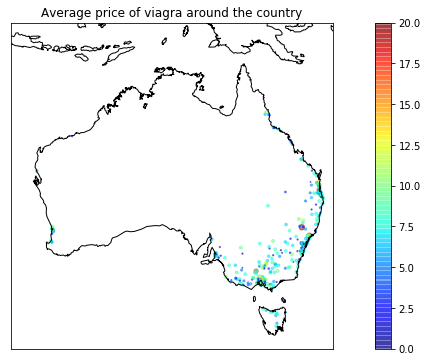

In [156]:
m = Basemap(llcrnrlon=110, llcrnrlat=-45, urcrnrlon=155, urcrnrlat=-5, projection='merc', resolution='l')
x, y = m(lon, lat)
fig, ax0 = pl.subplots(1, 1, figsize=(15, 6))
h0 = m.scatter(x, y, vg_pt_price, vg_pt_price, ax=ax0, cmap='jet', vmin=0, vmax=20, alpha=0.5)
m.drawcoastlines()
ax0.set_title('Average price of viagra around the country')
pl.colorbar(h0, ax=ax0)
pl.show()

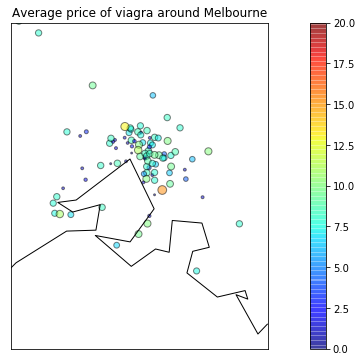

In [157]:
m = Basemap(llcrnrlon=144, llcrnrlat=-39, urcrnrlon=146, urcrnrlat=-37, projection='merc', resolution='l')
x, y = m(lon, lat)
fig, ax0 = pl.subplots(1, 1, figsize=(15, 6))
h0 = m.scatter(x, y, s=5*vg_pt_price, c=vg_pt_price, ax=ax0, cmap='jet', vmin=0, vmax=20, alpha=0.5, edgecolor='k')
m.drawcoastlines()
ax0.set_title('Average price of viagra around Melbourne')
pl.colorbar(h0, ax=ax0)
pl.show()

# Patients age.

In [122]:
viagra_patient_birth = np.array(new_viagra[~np.isnan(new_viagra.year_of_birth)].year_of_birth)
# viagra_patient_gender= viagra[~np.isnan(viagra.year_of_birth)].gender
viagra_prescription_date = np.array(new_viagra[~np.isnan(new_viagra.year_of_birth)].Prescription_Week, dtype=np.datetime64)

In [123]:
# The datetime type in numpy is just crazy, and not in a good way.
age = [vdp.astype('datetime64[Y]').astype(int)+1970 - vyb for vyb, vdp in zip(viagra_patient_birth, viagra_prescription_date)]

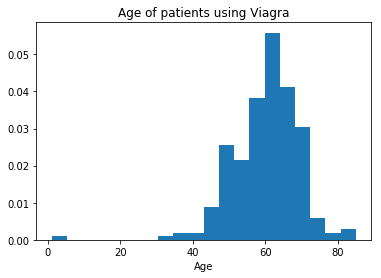

In [125]:
pl.hist(age, bins=20, normed=True)
pl.title('Age of patients using Viagra')
pl.xlabel('Age')
pl.show()

Just checking patients gender.

In [129]:
malev = new_viagra.gender[new_viagra.gender.str.contains('M')].count()
femalev = new_viagra.gender[new_viagra.gender.str.contains('F')].count()
undefv = new_viagra.gender[new_viagra.gender.str.contains('U')].count()

print("Male: ", malev)
print("Female: ", femalev)
print("Undef: ", undefv)

Male:  2559
Female:  226
Undef:  610
